In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [5]:
from astropy.io import fits

In [6]:
from __future__ import unicode_literals

figsize(8,6)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [7]:
rc = 107.2
dc = 5.2

In [8]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [9]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [48]:
def calculate_sflux_gal(bank='A', session='5', pixbeam=1., smth=None, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    c = coordinates.SkyCoord(frame='icrs', ra=ras*u.degree, dec=decs*u.degree)
    decs = c.galactic.b.deg
    ras = c.galactic.l.deg
    rc = 107.2
    dc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    varmap, varhits, rabins, decbins = naive_map(calibrated*calibrated, ras, decs, nrapix, ndecpix) 
    varmask = hits == 0
    varsignal = np.zeros_like(varmap)
    varsignal[~varmask] = varmap[~varmask] / varhits[~varmask] * units * units
    varsignal[~varmask] -= signal[~varmask]**2
    #varsignal[varmask] = np.nan
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= (45./60.)
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0

    annulus = (radius >= (60./60.) ) & (radius <= (90./60.))
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0

    sigma = beam / pixbeam / (2. * np.sqrt(2. * np.log(2)))
    signal = gaussian_filter(signal, sigma)
    shits = gaussian_filter(hits, sigma)
    svar = gaussian_filter(varsignal, sigma)
    mask = shits < 1
    
    rabinsc = (rabins[1:] + rabins[:-1]) / 2.
    decbinsc = (decbins[1:] + decbins[:-1]) / 2.
    if removeplane:
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
     
    if smth is not None:
        smth = np.sqrt(smth**2 - beam**2)
        sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
        signal = gaussian_filter(signal, sigma, mode='mirror')
        shits = gaussian_filter(hits, sigma)
        #mask = shits < 1
        
    signal -= np.nanmedian(signal[outerregion])
    signal[mask] = np.nan
    shits[mask] = np.nan
    svar[mask] = np.nan
    
    rdata = signal[innerregion]
    adata = signal[outerregion]
    flux = np.sum(rdata - np.median(adata))
    rms = np.std(adata) * np.sqrt(len(rdata) + pi/2. * float(len(rdata)**2) / len(adata))
    print flux, rms
    
    print np.sqrt(np.nansum(svar[innerregion]))
    print np.sum(innerregion)
    
    return signal, rabinsc, decbinsc, shits, svar, mask

In [49]:
signal, rabins, decbins, shits, svar, mask = calculate_sflux_gal('A', session='5', removeplane=True, smth=None)

24.9411963307 0.267921833826
0.325911659844
6379


In [23]:
rmsmap = np.zeros_like(svar)
rmsmap[~mask] = np.sqrt(svar[~mask])
rmsmap[mask] = np.nan

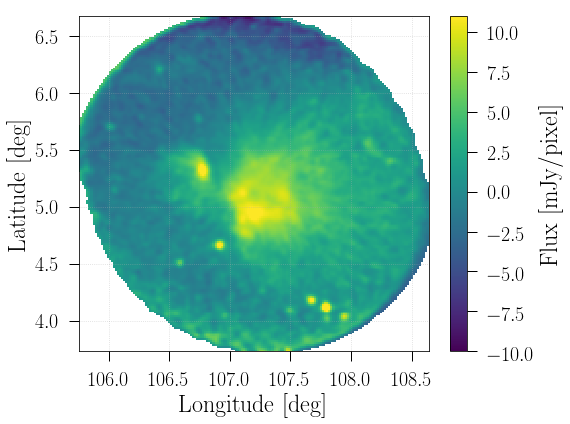

In [24]:
figure()
pc = pcolormesh(rabins, decbins, signal * 1000.)
clim(-10, 11)
cb = colorbar()
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
cb.set_label('$\mathrm{Flux\ [mJy / pixel]}$')
grid(ls='dotted', alpha=0.5)
#xlim(105.75, 108.63)
#ylim(3.73, 6.67)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()

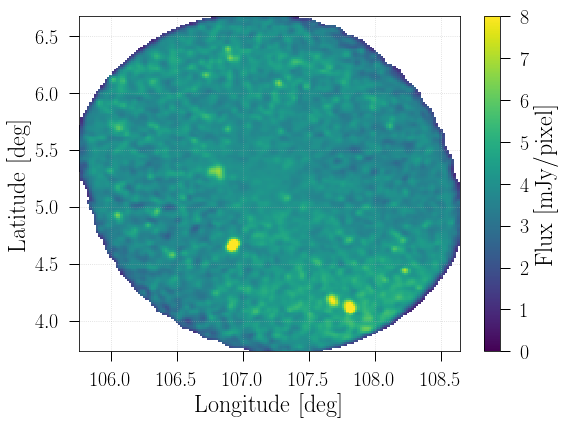

In [43]:
figure()
pc = pcolormesh(rabins, decbins, rmsmap * 1000., rasterized=True)
clim(-0, 8)
cb = colorbar()
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
cb.set_label('$\mathrm{Flux\ [mJy / pixel]}$')
grid(ls='dotted', alpha=0.5)
#xlim(105.75, 108.63)
#ylim(3.73, 6.67)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
savefig('rootvariancemap.pdf', format='pdf', dpi=300)

In [32]:
rmsmap.flatten().shape

(30448,)

In [40]:
rmsflat = rmsmap.flatten()
mask = rmsflat < 0.008

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


In [44]:
np.mean(rmsflat[mask])

0.0039341232037607941

In [45]:
np.median(rmsflat[mask])

0.003949778856809848

In [46]:
0.004 * 1000

4.0

In [50]:
0.004 * np.sqrt(6379)

0.31947456862792695

In [47]:
#4 mJy/pixel noise

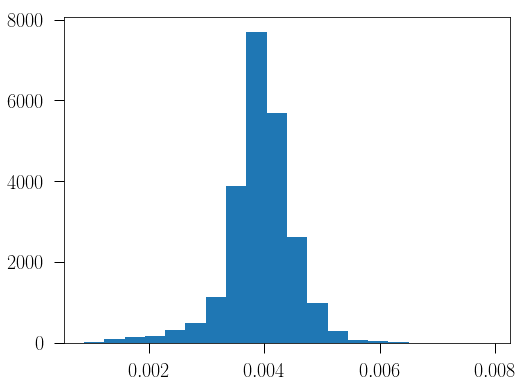

In [41]:
hist(rmsflat[mask], bins=20);

In [52]:
sigflat = signal.flatten()
mask = np.isnan(sigflat)

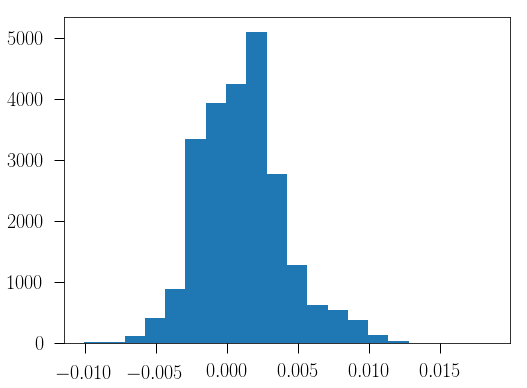

In [53]:
hist(sigflat[~mask], bins=20);

In [21]:
signal, rabins, decbins, shits = calculate_sflux_gal('A', session='5', removeplane=True, smth=40.)

17.2460625724 0.145934202933


In [22]:
signal, rabins, decbins, shits = calculate_sflux_gal('B', session='5', removeplane=True, smth=40.)

17.6230281334 0.213190397751


In [23]:
signal, rabins, decbins, shits = calculate_sflux_gal('C', session='5', removeplane=True, smth=40.)

18.9145124579 0.255520080333


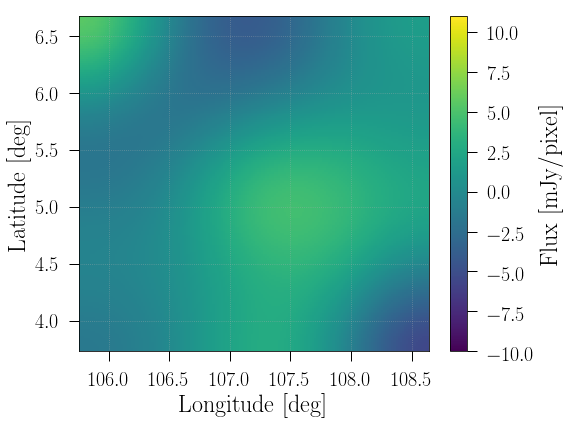

In [16]:
figure()
pc = pcolormesh(rabins, decbins, signal * 1000.)
clim(-10, 11)
cb = colorbar()
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
cb.set_label('$\mathrm{Flux\ [mJy / pixel]}$')
grid(ls='dotted', alpha=0.5)
#xlim(105.75, 108.63)
#ylim(3.73, 6.67)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()

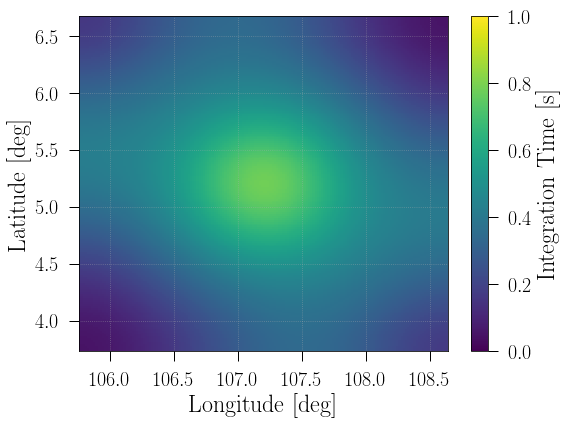

In [36]:
figure()
pc = pcolormesh(rabins, decbins, shits / 25.)
clim(0, 1.)
cb = colorbar()
xlabel('$\mathrm{Longitude\ [deg]}$')
ylabel('$\mathrm{Latitude\ [deg]}$')
cb.set_label('$\mathrm{Integration\ Time\ [s]}$')
grid(ls='dotted', alpha=0.5)
#xlim(105.75, 108.63)
#ylim(3.73, 6.67)
xticks([106, 106.5, 107, 107.5, 108, 108.5]);
tight_layout()
#savefig('integrationtime.pdf', format='pdf')

In [37]:
rdmesh = meshgrid(rabins, decbins)
radius_grid = np.sqrt( (rdmesh[0] - rc)**2 + (rdmesh[1] - dc)**2 ) 

In [38]:
rads = radius_grid.flatten()
fluxs = signal.flatten() * 1000.
mask = np.isnan(fluxs)
fluxs = fluxs[~mask]
rads = rads[~mask]

mask2 = rads <= 1.51
fluxs = fluxs[mask2]
rads = rads[mask2]

In [39]:
(rads.max() - rads.min()) * 60 / 2.

45.052214972804606

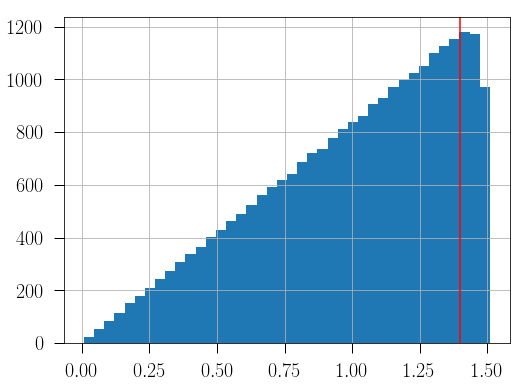

In [40]:
hist(rads, bins=40);
grid()
axvline(1.4, c='r')

In [41]:
hist, bins = np.histogram(rads, bins=45, weights=fluxs)

In [42]:
histnorm, bins2 = np.histogram(rads, bins=45)

In [43]:
np.diff(bins2)[0] * 60.

2.0023206654579826

In [44]:
bins = (bins[1:] + bins[:-1])/2.

In [45]:
bins2 = (bins2[1:] + bins2[:-1])/2.

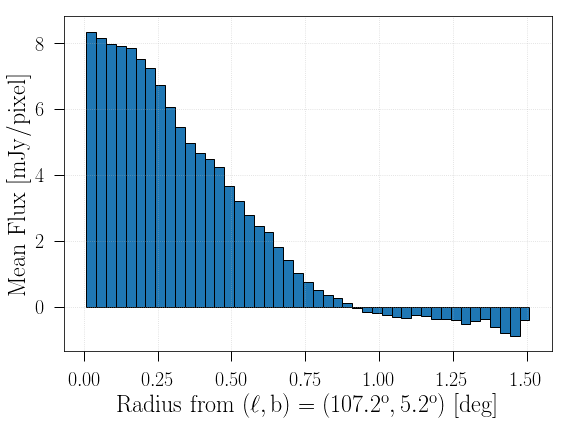

In [22]:
bar(x=bins, height=hist/histnorm, width=2./60, edgecolor='k')
grid(ls='dotted', alpha=0.5)
xlabel('$\mathrm{Radius\ from\ (\ell, b)=(107.2^o,5.2^o)\ [deg]}$')
ylabel('$\mathrm{Mean\ Flux\ [mJy/pixel]}$')
tight_layout()
#savefig('flux_radius_binned.pdf', format='pdf')

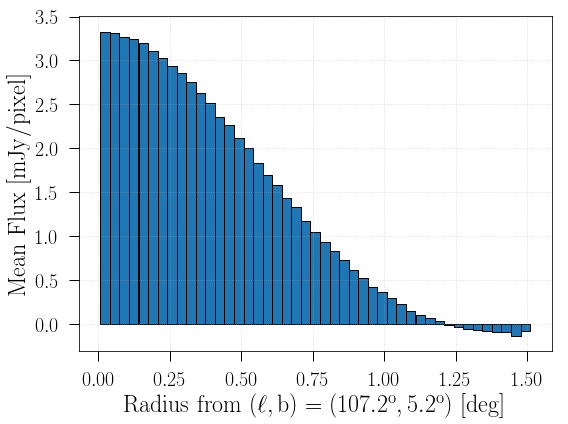

In [47]:
bar(x=bins, height=hist/histnorm, width=2./60, edgecolor='k')
grid(ls='dotted', alpha=0.5)
xlabel('$\mathrm{Radius\ from\ (\ell, b)=(107.2^o,5.2^o)\ [deg]}$')
ylabel('$\mathrm{Mean\ Flux\ [mJy/pixel]}$')
tight_layout()
savefig('flux_radius_binned_smoothed.pdf', format='pdf')

In [272]:
# plane not removed, median removed

Text(0,0.5,u'$\\mathrm{Mean\\ Flux\\ [mJy/pixel]}$')

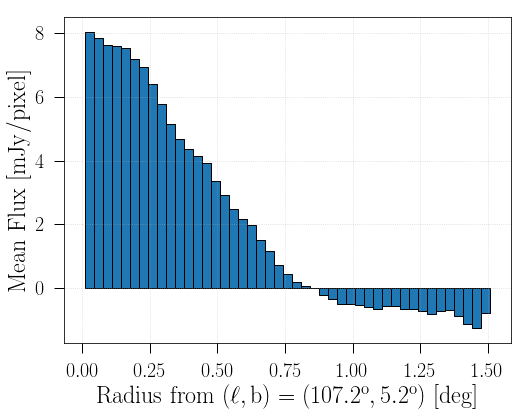

In [247]:
bar(x=bins, height=hist/histnorm, width=2./60, edgecolor='k')
grid(ls='dotted', alpha=0.5)
xlabel('$\mathrm{Radius\ from\ (\ell, b)=(107.2^o,5.2^o)\ [deg]}$')
ylabel('$\mathrm{Mean\ Flux\ [mJy/pixel]}$')
#savefig('fluxvsradius')

In [273]:
# plane not removed, median not removed

Text(0,0.5,u'$\\mathrm{Mean\\ Flux\\ [mJy/pixel]}$')

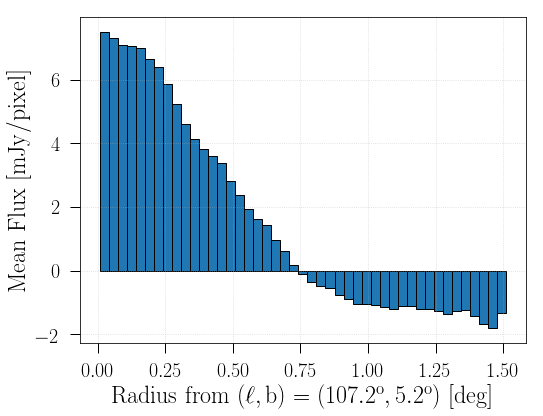

In [259]:
bar(x=bins, height=hist/histnorm, width=2./60, edgecolor='k')
grid(ls='dotted', alpha=0.5)
xlabel('$\mathrm{Radius\ from\ (\ell, b)=(107.2^o,5.2^o)\ [deg]}$')
ylabel('$\mathrm{Mean\ Flux\ [mJy/pixel]}$')
#savefig('fluxvsradius')